# 1 画像の取り込み

In [1]:
# 参考グラフ　LTV-217：https://optoelectronics.liteon.com/upload/download/DS70-2009-0016/LTV-2X7%20sereis%20201610.pdf

## 画像読み取り→グレースケール変換

In [76]:
import cv2

def load_gray_image(path: str):
    """
    in : 画像ファイルパス
    out: グレースケール画像（numpy.ndarray）
    """
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise FileNotFoundError(f"画像が読み込めへんで: {path}")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    return gray


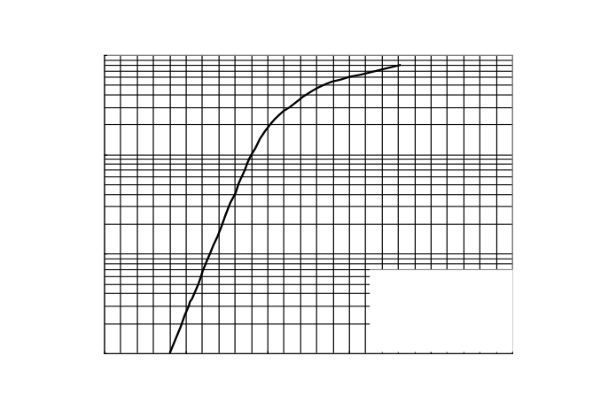

In [77]:
import cv2
import matplotlib.pyplot as plt

# 画像ファイルパス
IMAGE_PATH = "10_test_data/VF_VS_IF.png"

# 画像読み込み（OpenCVはBGR）
img_bgr = cv2.imread(IMAGE_PATH)

if img_bgr is None:
    raise FileNotFoundError("画像が読み込めへんで。パス確認してな。")

# RGBに変換
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# img は RGB（numpy配列）前提
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(6, 4))
plt.imshow(gray, cmap="gray")
plt.axis("off")
plt.show()


1️⃣ グリッド線除去（モルフォロジー）<br>
2️⃣ 二値化　<br>
3️⃣ 曲線ピクセル抽出 <br>
4️⃣ log軸キャリブレーション <br>

In [78]:
import cv2

# 反転二値化（線を白にする）
_, bw = cv2.threshold(
    gray, 0, 255,
    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)


In [79]:
plt.imshow(bw)

## 横グリッド抽出

In [80]:
import numpy as np

# 横線用カーネル（幅は画像サイズ依存）
h_kernel = cv2.getStructuringElement(
    cv2.MORPH_RECT,
    (40, 1)   # ← 横に長い
)

horizontal_lines = cv2.morphologyEx(
    bw, cv2.MORPH_OPEN, h_kernel
)



In [81]:
plt.imshow(horizontal_lines)

## 同様に縦グリッドも行う

In [82]:
v_kernel = cv2.getStructuringElement(
    cv2.MORPH_RECT,
    (1, 40)   # ← 縦に長い
)

vertical_lines = cv2.morphologyEx(
    bw, cv2.MORPH_OPEN, v_kernel
)


In [137]:
plt.imshow(vertical_lines)

In [84]:
## グリッド線をまとめて消す

In [85]:
grid = cv2.bitwise_or(horizontal_lines, vertical_lines)

# グリッドを除去
bw_no_grid = cv2.subtract(bw, grid)


In [86]:
plt.imshow(bw_no_grid)

In [87]:
## 連結成分解析で小ノイズ除去

In [88]:
import cv2
import numpy as np

# 連結成分解析
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
    bw_no_grid, connectivity=8
)

# 面積しきい値（ここ要調整）
MIN_AREA = 10

clean = np.zeros_like(bw_no_grid)

for i in range(1, num_labels):  # 0は背景
    area = stats[i, cv2.CC_STAT_AREA]
    if area >= MIN_AREA:
        clean[labels == i] = 255


In [89]:
plt.imshow(clean)

In [90]:
## 切れかけたグラフをつなぐ

In [91]:
## TBD　ここもう少しチューニングが必要！！！

In [92]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
clean2 = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel)


In [93]:
plt.imshow(clean2)

In [94]:
##曲線→座標変換

In [95]:

# 白ピクセル（曲線）の座標を取得
ys, xs = np.where(clean2 > 0)

In [96]:
points = np.column_stack((xs, ys))


In [97]:
## 線の真ん中の値をなぞる

In [98]:
from collections import defaultdict
import numpy as np

x_to_ys = defaultdict(list)

for x, y in points:
    x_to_ys[x].append(y)

curve_xy = []

for x in sorted(x_to_ys.keys()):
    y_med = int(np.median(x_to_ys[x]))
    curve_xy.append((x, y_med))

curve_xy = np.array(curve_xy)


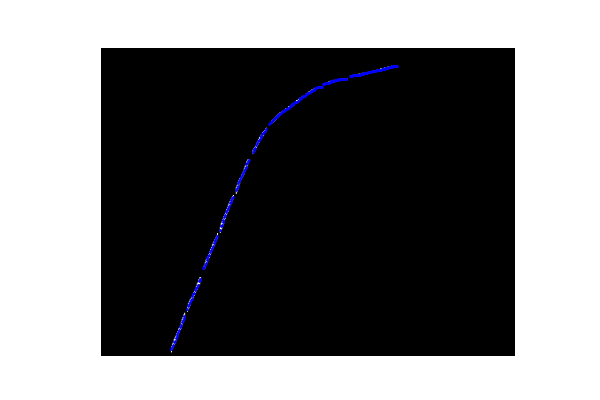

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.imshow(clean2, cmap="gray")
plt.plot(curve_xy[:,0], curve_xy[:,1], 'b.', markersize=2)
plt.axis("off")
plt.show()


In [100]:
clean2.shape

(348, 467)

In [101]:
curve_xy

array([[ 79, 340],
       [ 80, 337],
       [ 81, 335],
       [ 82, 332],
       [ 83, 330],
       [ 84, 327],
       [ 85, 325],
       [ 86, 323],
       [ 87, 320],
       [ 88, 318],
       [ 89, 315],
       [ 90, 312],
       [ 91, 309],
       [ 92, 307],
       [ 93, 304],
       [ 94, 302],
       [ 97, 294],
       [ 98, 291],
       [ 99, 289],
       [100, 287],
       [101, 284],
       [102, 283],
       [103, 280],
       [104, 278],
       [105, 276],
       [106, 273],
       [107, 271],
       [108, 269],
       [109, 267],
       [110, 263],
       [111, 262],
       [112, 260],
       [115, 248],
       [116, 247],
       [117, 245],
       [118, 242],
       [119, 239],
       [120, 237],
       [121, 235],
       [122, 233],
       [123, 230],
       [124, 228],
       [125, 225],
       [126, 223],
       [127, 220],
       [128, 218],
       [129, 216],
       [130, 214],
       [131, 212],
       [134, 205],
       [135, 201],
       [136, 199],
       [137,

In [102]:
## 曲線とラベルの幾何学的特徴を使ってラベルをマスクする

In [103]:
import numpy as np

xs, ys = np.where(clean2> 0)

# xごとの出現数をカウント
unique_x, counts = np.unique(xs, return_counts=True)

# しきい値（要チューニング）
MIN_X_SPAN = 10

valid_x = unique_x[counts > 2]  # 1〜2点しかないxは怪しい

# xの連続区間を抽出
from itertools import groupby
from operator import itemgetter

def consecutive_groups(data):
    for _, g in groupby(enumerate(data), lambda x: x[0]-x[1]):
        yield list(map(itemgetter(1), g))

groups = list(consecutive_groups(valid_x))

# 一番長いx区間だけ採用（＝曲線）
main_x_group = max(groups, key=len)

mask = np.isin(xs, main_x_group)

xs_f = xs[mask]
ys_f = ys[mask]


In [104]:
# from collections import defaultdict
# import numpy as np

# curve = []

# x_to_ys = defaultdict(list)
# # フィルタ後の点だけ使う
# for x, y in zip(xs_f, ys_f):
#     x_to_ys[x].append(y)

# for x in sorted(x_to_ys.keys()):
#     y_med = int(np.median(x_to_ys[x]))
#     curve.append((x, y_med))

# curve = np.array(curve)


In [105]:
## xごとの y を「中央値 → 移動平均」

In [106]:
curve = []

for x in range(clean2.shape[1]):
    ys = np.where(clean2[:, x] > 0)[0]
    if len(ys) == 0:
        continue
    curve.append((x, int(np.median(ys))))
curve = np.array(curve)


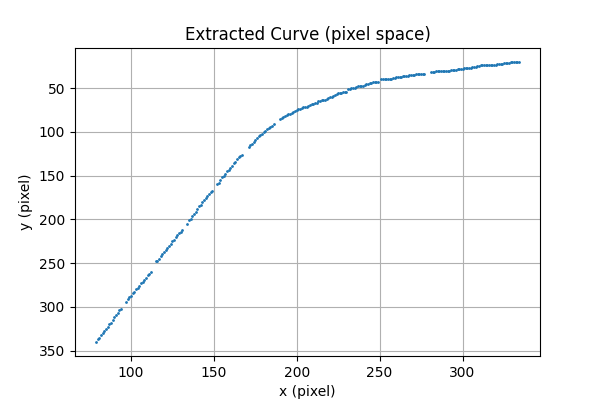

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(curve[:,0], curve[:,1], '.', markersize=2)
plt.gca().invert_yaxis()  # 画像座標系なので上下反転
plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.title("Extracted Curve (pixel space)")
plt.grid(True)
plt.show()

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector


Text(0, 0.5, 'y (pixel)')

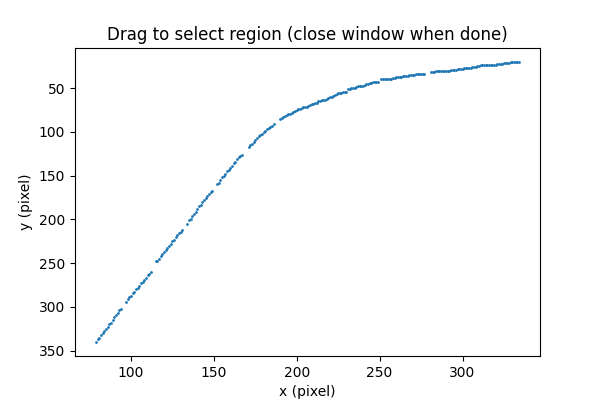

In [109]:
curve = np.array(curve)  # 念のため

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(curve[:,0], curve[:,1], '.', markersize=2)
ax.invert_yaxis()
ax.set_title("Drag to select region (close window when done)")
ax.set_xlabel("x (pixel)")
ax.set_ylabel("y (pixel)")


In [110]:
## TBD GUIでいらない領域を選択したい

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector


def gui_mask_curve(curve, mode="remove"):
    """
    curve : np.ndarray (N,2)  [x, y] pixel coordinates
    mode  : "remove" -> 選択領域を削除
            "keep"   -> 選択領域だけ残す

    return : curve_filtered (np.ndarray)
    """

    curve = np.asarray(curve)

    selected_boxes = []

    # --- コールバック ---
    def onselect(eclick, erelease):
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata

        if x1 is None or x2 is None:
            return

        xmin, xmax = sorted([x1, x2])
        ymin, ymax = sorted([y1, y2])

        selected_boxes.append((xmin, xmax, ymin, ymax))
        print(f"Selected box: x[{xmin:.1f}, {xmax:.1f}], y[{ymin:.1f}, {ymax:.1f}]")

    # --- 表示 ---
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(curve[:, 0], curve[:, 1], ".", markersize=2)
    ax.invert_yaxis()
    ax.set_title("Drag rectangle to select area\n(close window when done)")
    ax.set_xlabel("x (pixel)")
    ax.set_ylabel("y (pixel)")

    rect_selector = RectangleSelector(
    ax,
    onselect,
    useblit=True,
    button=[1],          # 左クリック
    minspanx=5,
    minspany=5,
    spancoords="data",
    interactive=True
)


    plt.show()   # ← ウィンドウを閉じたら次へ進む

    # --- マスク処理 ---
    if mode == "remove":
        mask = np.ones(len(curve), dtype=bool)
        for xmin, xmax, ymin, ymax in selected_boxes:
            inside = (
                (curve[:, 0] >= xmin) & (curve[:, 0] <= xmax) &
                (curve[:, 1] >= ymin) & (curve[:, 1] <= ymax)
            )
            mask &= ~inside

    elif mode == "keep":
        mask = np.zeros(len(curve), dtype=bool)
        for xmin, xmax, ymin, ymax in selected_boxes:
            inside = (
                (curve[:, 0] >= xmin) & (curve[:, 0] <= xmax) &
                (curve[:, 1] >= ymin) & (curve[:, 1] <= ymax)
            )
            mask |= inside
    else:
        raise ValueError("mode must be 'remove' or 'keep'")

    curve_filtered = curve[mask]

    # --- 結果確認 ---
    plt.figure(figsize=(6, 4))
    plt.plot(curve[:, 0], curve[:, 1], ".", color="gray", markersize=2, label="before")
    plt.plot(curve_filtered[:, 0], curve_filtered[:, 1], "r.", markersize=2, label="after")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.title("Curve after GUI masking")
    plt.show()

    return curve_filtered


In [112]:
len(curve[:,0])

238

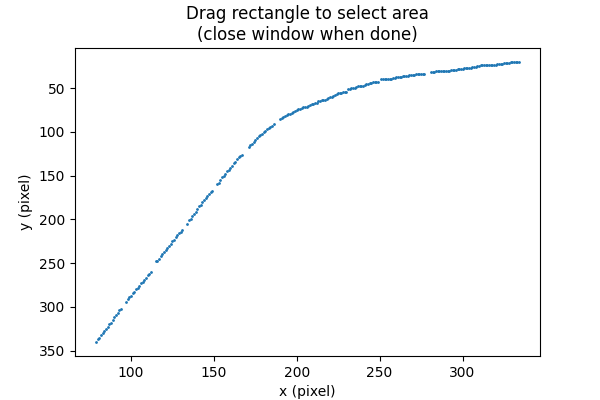

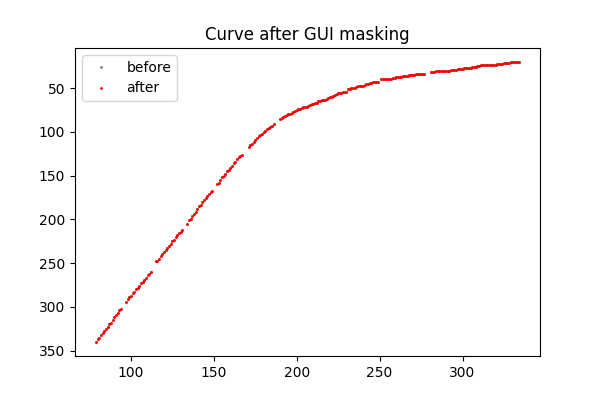

In [113]:
%matplotlib widget 
# ↑jupyterでインタラクティブモードにするために必要
curve = np.array(curve)  # 既存のcurve

curve_clean = gui_mask_curve(curve, mode="remove")


In [114]:
## 軸キャリブレーション

In [115]:
## ユーザから軸のmin-maxとlinear/logを入力してもら

In [116]:
def make_axis_values(real_min, real_max, n, scale):
    if scale == "linear":
        return np.linspace(real_min, real_max, n)
    elif scale == "log":
        return np.logspace(np.log10(real_min), np.log10(real_max), n)


In [117]:
# ↓ユーザが入力する項目
y_max_real = 1000
y_min_real = 1
y_scale = "log"

x_max_real = 3
x_min_real = 0.5
x_scale = "linear"

y_grid_real = make_axis_values(
    y_max_real, y_min_real,  # 上が最大なので逆
    len(curve[:,0]),
    y_scale
)

x_grid_real = make_axis_values(
    x_max_real, x_min_real,  # 上が最大なので逆
    len(curve[:,1]),
    x_scale
)


In [ ]:
## 縦横のpixlのgridを作る

import numpy as np

def extract_y_grid_px(horizontal_lines, merge_tol=2):
    """
    horizontal_lines : 二値画像（横グリッド線=255）
    merge_tol        : 同一線とみなすy方向の許容pixel差

    return : np.ndarray (y_grid_px)  上→下にソート済み
    """
    ys, xs = np.where(horizontal_lines > 0)

    if len(ys) == 0:
        raise ValueError("horizontal grid not detected")

    ys_sorted = np.sort(ys)

    y_grid_px = []
    cluster = [ys_sorted[0]]

    for y in ys_sorted[1:]:
        if abs(y - cluster[-1]) <= merge_tol:
            cluster.append(y)
        else:
            y_grid_px.append(int(np.mean(cluster)))
            cluster = [y]

    y_grid_px.append(int(np.mean(cluster)))

    return np.array(sorted(y_grid_px))


def extract_x_grid_px(vertical_lines, merge_tol=2):
    """
    vertical_lines : 二値画像（縦グリッド線=255）
    merge_tol      : 同一線とみなすx方向の許容pixel差

    return : np.ndarray (x_grid_px)  左→右にソート済み
    """
    ys, xs = np.where(vertical_lines > 0)

    if len(xs) == 0:
        raise ValueError("vertical grid not detected")

    xs_sorted = np.sort(xs)

    x_grid_px = []
    cluster = [xs_sorted[0]]

    for x in xs_sorted[1:]:
        if abs(x - cluster[-1]) <= merge_tol:
            cluster.append(x)
        else:
            x_grid_px.append(int(np.mean(cluster)))
            cluster = [x]

    x_grid_px.append(int(np.mean(cluster)))

    return np.array(sorted(x_grid_px))


In [48]:
def pixel_to_real_by_grid(px, grid_px, grid_real, scale):
    """
    px         : scalar or array
    grid_px    : sorted pixel positions
    grid_real  : corresponding real values
    scale      : linear / log
    """
    px = np.asarray(px)
    real = np.zeros_like(px, dtype=float)

    for i in range(len(grid_px) - 1):
        mask = (px >= grid_px[i]) & (px <= grid_px[i+1])
        t = (px[mask] - grid_px[i]) / (grid_px[i+1] - grid_px[i])

        if scale == "linear":
            real[mask] = grid_real[i] + t * (grid_real[i+1] - grid_real[i])
        else:  # log
            real[mask] = 10 ** (
                np.log10(grid_real[i]) +
                t * (np.log10(grid_real[i+1]) - np.log10(grid_real[i]))
            )

    return real


In [53]:
y_grid_px = extract_y_grid_px(horizontal_lines)
x_grid_px = extract_x_grid_px(vertical_lines)


In [54]:
x_px = curve[:, 0]
y_px = curve[:, 1]

x_real = pixel_to_real_by_grid(
    x_px,
    x_grid_px,
    x_grid_real,
    scale="linear"
)

y_real = pixel_to_real_by_grid(
    y_px,
    y_grid_px,
    y_grid_real,
    scale="log"
)


In [129]:
horizontal_lines.shape

(348, 467)

In [130]:
vertical_lines.shape

(348, 467)

In [131]:
curve.shape

(238, 2)

In [160]:
for px, rv in zip(y_px, y_real):
    print(f"y_px={px:.1f} -> y_real={rv}")


y_px=79.0 -> y_real=195.172741131439
y_px=80.0 -> y_real=191.17765303444406
y_px=81.0 -> y_real=187.26434238654466
y_px=82.0 -> y_real=183.43113524438417
y_px=83.0 -> y_real=179.67639192938614
y_px=84.0 -> y_real=175.99850632637217
y_px=85.0 -> y_real=172.39590519653584
y_px=86.0 -> y_real=168.86704750447973
y_px=87.0 -> y_real=165.41042375902788
y_px=88.0 -> y_real=162.0245553675318
y_px=89.0 -> y_real=158.70799400339232
y_px=90.0 -> y_real=155.45932098652912
y_px=91.0 -> y_real=152.27714667653194
y_px=92.0 -> y_real=149.16010987823196
y_px=93.0 -> y_real=146.1068772594429
y_px=94.0 -> y_real=143.11614278061933
y_px=97.0 -> y_real=134.5062655259169
y_px=98.0 -> y_real=131.75298974950124
y_px=99.0 -> y_real=129.05607214696946
y_px=100.0 -> y_real=126.41435909477609
y_px=101.0 -> y_real=123.82672058347052
y_px=102.0 -> y_real=121.29204973432878
y_px=103.0 -> y_real=118.80926232587915
y_px=104.0 -> y_real=116.37729633011945
y_px=105.0 -> y_real=113.99511145822792
y_px=106.0 -> y_real=111

In [139]:
## debug

In [184]:
import numpy as np

def px_to_real_minmax(px, px_min, px_max, real_min, real_max, scale="linear"):
    px = np.asarray(px, dtype=float)
    t = (px - px_min) / (px_max - px_min)

    if scale == "linear":
        return real_min + t * (real_max - real_min)

    if scale == "log":
        return 10 ** (np.log10(real_min) + t * (np.log10(real_max) - np.log10(real_min)))

    raise ValueError("scale must be 'linear' or 'log'")

def px_to_real(y_px, y_px_max, y_min, y_max, scale="linear"):
    """
    y_px      : pixel y (0 = 上)
    y_px_max  : pixel y の最大値（下端）
    y_min     : 実値の最小（例 1）
    y_max     : 実値の最大（例 1000）
    """
    y_px = np.asarray(y_px, dtype=float)

    # 0〜1 に正規化（上→下）
    t = y_px / y_px_max

    if scale=="log":
        # log空間で反転線形補間
        log_y = np.log10(y_max) * (1 - t) + np.log10(y_min) * t

        return 10 ** log_y
    if scale=="linear":
        return y_min + t*(y_max-y_min) 
    
    raise ValueError("scale must be 'linear' or 'log'")

In [174]:
clean2.shape

(348, 467)

In [189]:
x_px = curve[:,1]
y_px = curve[:,0]

# ROI座標系での端
x_px_min, x_px_max = 0, clean2.shape[1]
y_px_min, y_px_max = 0, clean2.shape[0]

# ユーザ入力
x_min, x_max = 0.5, 3.0
y_min, y_max = 1.0, 1000.0

# x: 左→右が min→max
# x_real = px_to_real_minmax(x_px, x_px_min, x_px_max, x_min, x_max, scale="linear")
x_real = px_to_real(x_px, x_px_max, x_min, x_max, scale="linear")
# y: 上→下が max→min （ここがポイント）
y_real = px_to_real(y_px, y_px_max, y_min, y_max, scale="log")


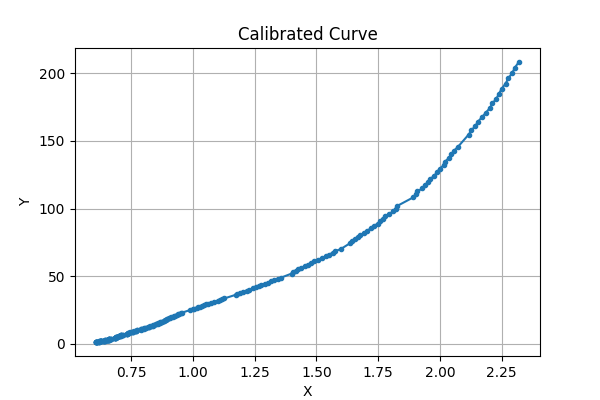

In [190]:
plt.figure(figsize=(6, 4))
plt.plot(x_real, y_real, '-o', markersize=3)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.title("Calibrated Curve")
plt.show()

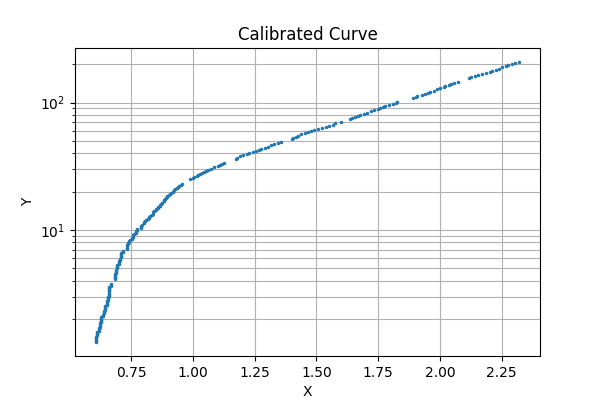

In [191]:
plt.figure(figsize=(6,4))
plt.plot(x_real, y_real, '.', markersize=3)
plt.yscale("log")              # ← これ
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True, which="both")   # log軸は both 推奨
plt.title("Calibrated Curve")
plt.show()


In [194]:
x_real

array([2.32012848, 2.30406852, 2.29336188, 2.27730193, 2.26659529,
       2.25053533, 2.23982869, 2.22912206, 2.2130621 , 2.20235546,
       2.1862955 , 2.17023555, 2.15417559, 2.14346895, 2.12740899,
       2.11670236, 2.0738758 , 2.05781585, 2.04710921, 2.03640257,
       2.02034261, 2.01498929, 1.99892934, 1.9882227 , 1.97751606,
       1.9614561 , 1.95074946, 1.94004283, 1.92933619, 1.90792291,
       1.90256959, 1.89186296, 1.82762313, 1.82226981, 1.81156317,
       1.79550321, 1.77944325, 1.76873662, 1.75802998, 1.74732334,
       1.73126338, 1.72055675, 1.70449679, 1.69379015, 1.67773019,
       1.66702355, 1.65631692, 1.64561028, 1.63490364, 1.59743041,
       1.57601713, 1.56531049, 1.54925054, 1.5385439 , 1.52248394,
       1.50642398, 1.49036403, 1.47965739, 1.46359743, 1.45289079,
       1.43683084, 1.4261242 , 1.41541756, 1.40471092, 1.3993576 ,
       1.35653105, 1.34582441, 1.32976445, 1.3137045 , 1.30299786,
       1.29229122, 1.27623126, 1.26552463, 1.25481799, 1.24411

In [193]:
y_real

array([208.43253822, 204.33597179, 200.31991993, 196.38280019,
       192.52306124, 188.73918221, 185.02967215, 181.39306939,
       177.827941  , 174.33288222, 170.90651588, 167.54749189,
       164.2544867 , 161.02620276, 157.86136802, 154.75873546,
       145.81194512, 142.94613384, 140.13664767, 137.38237959,
       134.68224433, 132.03517797, 129.44013747, 126.89610032,
       124.40206407, 121.95704602, 119.56008273, 117.21022975,
       114.90656116, 112.64816923, 110.43416411, 108.26367339,
       102.00481902, 100.        ,  98.03458401,  96.10779662,
        94.21887862,  92.36708572,  90.55168825,  88.77197089,
        87.02723238,  85.31678524,  83.6399555 ,  81.99608245,
        80.38451833,  78.80462816,  77.2557894 ,  75.73739176,
        74.24883695,  69.95642157,  68.58148687,  67.23357536,
        65.91215593,  64.61670787,  63.34672077,  62.10169419,
        60.88113756,  59.68456995,  58.51151987,  57.3615251 ,
        56.23413252,  55.12889789,  54.04538571,  52.98